In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Aggregate transaction data
transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # Total spend, average spend, no. of transactions
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()
transaction_summary.columns = ['CustomerID', 'TotalSpend', 'AvgSpend', 'TransactionCount', 'TotalQuantity']

In [4]:
# Merge with customer data
data = pd.merge(customers, transaction_summary, on='CustomerID', how='inner')

In [5]:
# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = ['Region']  # Add other categorical columns if necessary
encoded_data = encoder.fit_transform(data[categorical_features])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

In [6]:
# Combine all features
numeric_features = ['TotalSpend', 'AvgSpend', 'TransactionCount', 'TotalQuantity']
final_data = pd.concat([data[numeric_features], encoded_df], axis=1)

In [7]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data)

In [22]:
# Clustering (K-Means example)
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, clusters)
    db_scores.append((k, db_index))
    print(f'Clusters: {k}, DB Index: {db_index}')

Clusters: 2, DB Index: 1.5307150504819598
Clusters: 3, DB Index: 1.3727555425721158
Clusters: 4, DB Index: 1.214376962678693
Clusters: 5, DB Index: 1.165821526565192
Clusters: 6, DB Index: 1.1937487027519944
Clusters: 7, DB Index: 1.1214435502653477
Clusters: 8, DB Index: 1.1251760011256966
Clusters: 9, DB Index: 1.0811489761089765
Clusters: 10, DB Index: 1.0320144176911827


In [24]:
# Choose the optimal number of clusters
optimal_k = min(db_scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_clusters = kmeans.fit_predict(scaled_data)

In [25]:
# Add cluster labels to the data
data['Cluster'] = final_clusters

In [26]:
# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
data['PCA1'], data['PCA2'] = pca_result[:, 0], pca_result[:, 1]

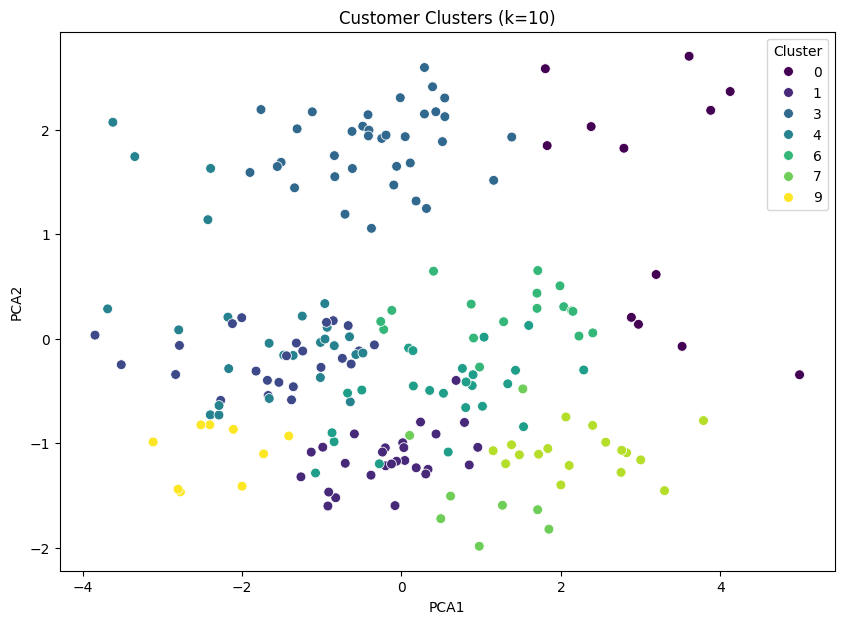

In [27]:
# Visualize clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title(f'Customer Clusters (k={optimal_k})')
plt.show()

In [21]:
# Save the clustering results
data.to_csv('Customer_Clusters.csv', index=False)